* To investigate the forcings on stratification and total currents. 

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    stormtools
)
import datetime, os
from glob import glob
from IPython.core.display import Image,display
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib as mpl
import pytz 
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {'lat': 49.10,'lon': -123.30,'j' : 46,'i' : 53},
    'Steveston':{
        'j': 48, ##428
        'i': 52, ##292
    },
    'VENUS East':{'lat': 49.0419, 'lon': -123.3176,'depth': 170, 'j': 36, 'i': 43},    
    'VENUS Central':{ 'lat': 49.0401,'lon': -123.4261, 'depth': 300, 'j': 44, 'i': 26 },
    'Point on transect':{'j':36,'i':20},
    'mouth':{ 'j':39,'i':74},
    'near field':{'j':43,'i':64},
    'estuary':{'j':36,'i':102},
    }

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]

* Load model result

* Only river

In [4]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')

* No tides

In [5]:
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_U.nc')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_V.nc')

* No winds

In [6]:
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')

* No f

In [7]:
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')

 * Combine all forcings

In [8]:
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')

In [9]:
def plot_stratification_current(stn, dep_ind,ty,grid_T,grid_U,grid_V,time_ind,\
                                smin = 0,smax = 36,umin = -0.5,umax = 0.5):
    """This function is made to plot the 
    stratification and horizontal current of a specific station """
    S = grid_T.variables['vosaline']
    t = grid_T.variables['time_counter']
    dep_T = grid_T.variables['deptht']
    U = grid_U.variables['vozocrtx']
    dep_U = grid_U.variables['depthu']
    V = grid_V.variables['vomecrty']
    dep_V = grid_V.variables['depthv']
    S_stn = S[:,:,sites[stn]['j'],sites[stn]['i']]
    ## tmask
    mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
    tmask = mesh.variables['tmask'][0,:,sites[stn]['j']+380,sites[stn]['i']+240]
    np_mask = np.abs(1-tmask) 
    np_mask=np_mask +np.zeros(S_stn.shape) 
    S_stn = np.ma.masked_array(S_stn,mask=np_mask) ## mask sal=0 by tmask
    time_inds = np.arange(S.shape[0]) ## Define time
    fig, axs = plt.subplots(1,3,figsize = (22,4))
    ## stratification
    ax = axs[0]
    mesh = ax.contourf(time_inds, dep_T[:],np.transpose(S_stn[:]),np.arange(smin, smax+3, 3),cmap = 'jet')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('Practical Salinity')
    ax.set_title(ty+' stratification of '+stn)
    ## U current
    ax = axs[1]
    UU,VV = viz_tools.unstagger(U[:,:,sites[stn]['j']:sites[stn]['j']+2,sites[stn]['i']:sites[stn]['i']+2],\
                                V[:,:,sites[stn]['j']:sites[stn]['j']+2,sites[stn]['i']:sites[stn]['i']+2])
    #rotate
    theta = np.pi*29/180
    UU = UU*np.cos(theta) - VV*np.sin(theta)
    VV = UU*np.sin(theta) +VV*np.cos(theta)

    mesh = ax.contourf(time_inds, dep_U[:],np.transpose(UU[:,:,0,0]),np.arange(umin,umax+0.01,0.02),cmap = 'bwr')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('U Velocity [m/s]')
    ax.set_title(ty+' U velocity of '+stn)
    #print ('Max U', np.nanmax(UU[:,:,0,0]))
    #print ('Min U', np.nanmin(UU[:,:,0,0]))
    ## V current
    ax = axs[2]
    mesh = ax.contourf(time_inds, dep_V[:],np.transpose(VV[:,:,0,0]),np.arange(umin,umax+0.01,0.02),cmap = 'bwr')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('V Velocity [m/s]')
    ax.set_title(ty+' V velocity of '+stn)
    #print ('Max V', np.nanmax(VV[:,:,0,0]))
    #print ('Min V', np.nanmin(VV[:,:,0,0]))
    
    for ax, dep in zip(axs,[dep_T,dep_U,dep_V]):
        ax.set_ylim([dep[dep_ind], dep[0]])
        ax.set_xlim(time_inds[time_ind],time_inds[-1])
        ax.set_xlabel('Time [hr]')
        ax.set_ylabel('Depth [m]')
    return fig

In [10]:
def plot_stn(stn_name):
    """Label the stn """
    fig, ax = plt.subplots(1,1,figsize = (5,5))
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.plot(X[sites[stn_name]['j']+380,sites[stn_name]['i']+240],\
            Y[sites[stn_name]['j']+380,sites[stn_name]['i']+240],'g*',markersize = 10,label = stn_name)
    ax.set_xlim([-123.6,-122.9])
    ax.set_ylim([48.95,49.4])
    ax.legend()
    plt.show()

# Stratification and horizontal currents

* estuary

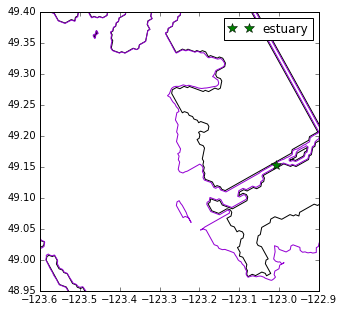

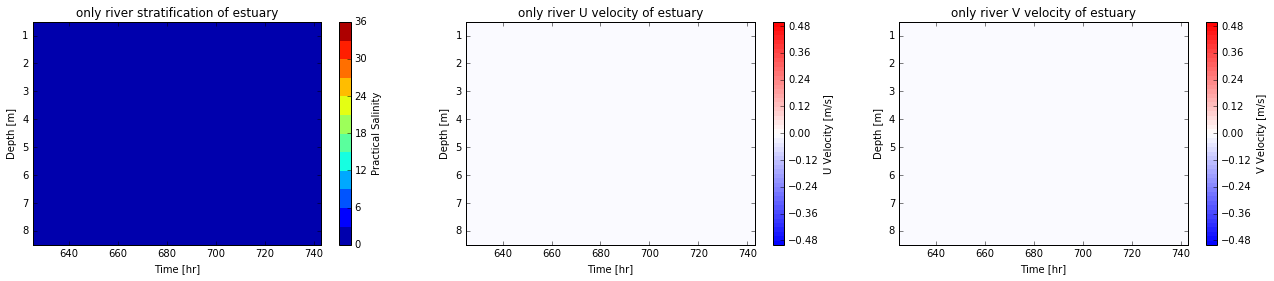

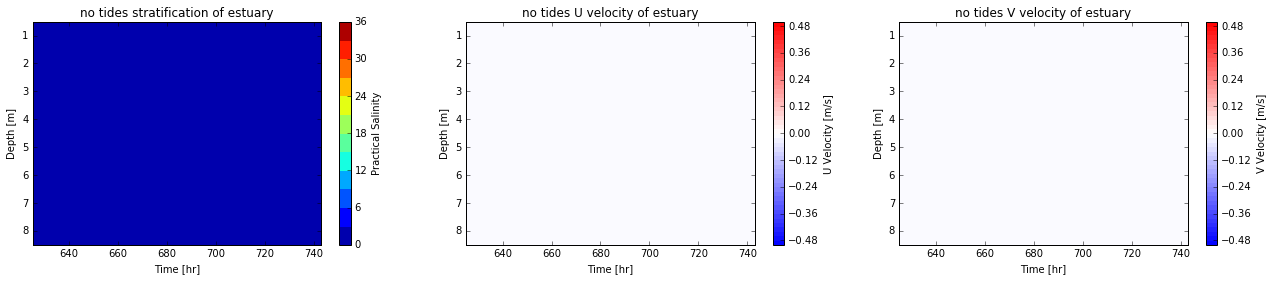

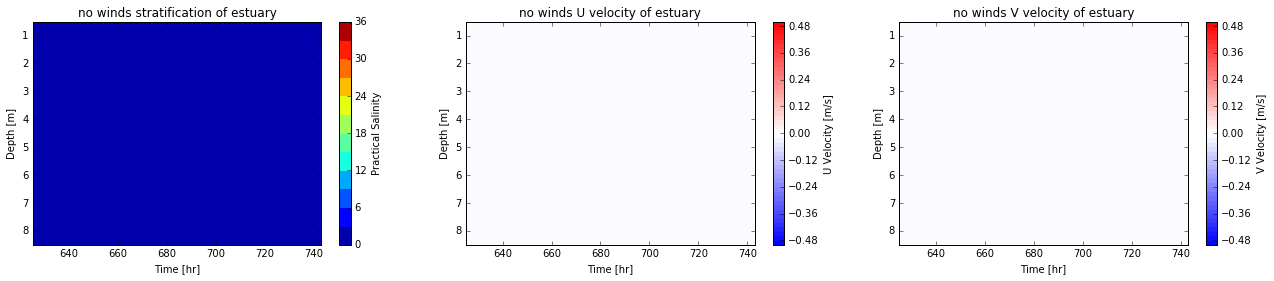

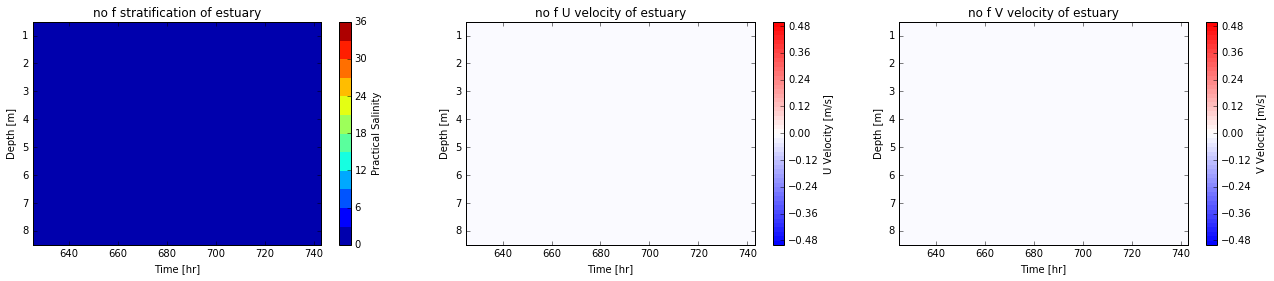

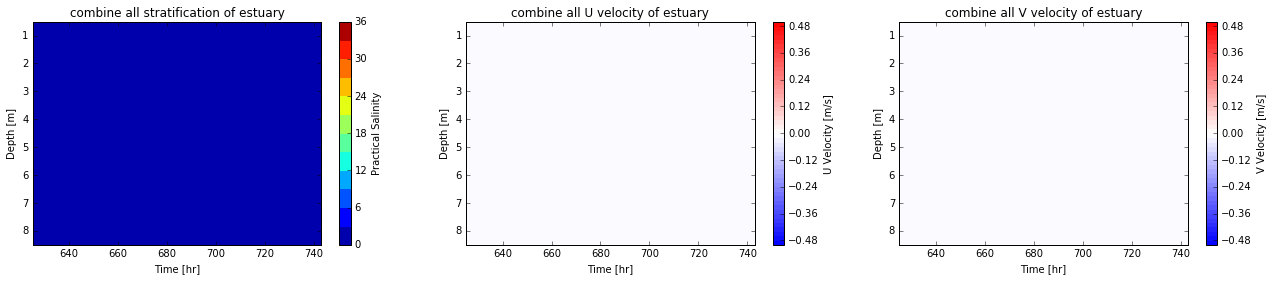

In [11]:
plot_stn('estuary')
fig = plot_stratification_current('estuary',8,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('estuary',8,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('estuary',8,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('estuary',8,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('estuary',8,'combine all',all_T,all_U,all_V,625)

* Mouth

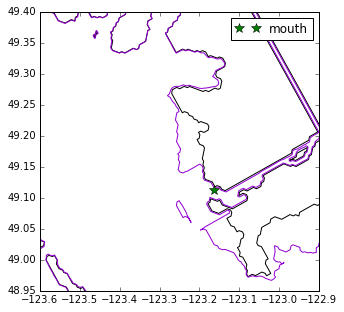

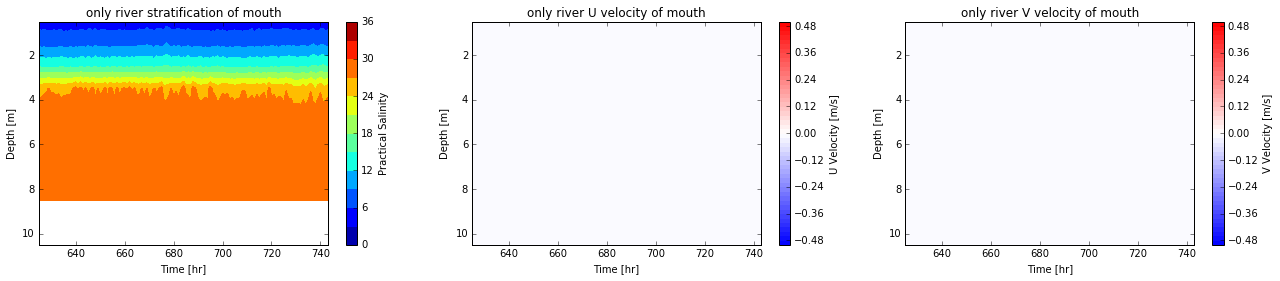

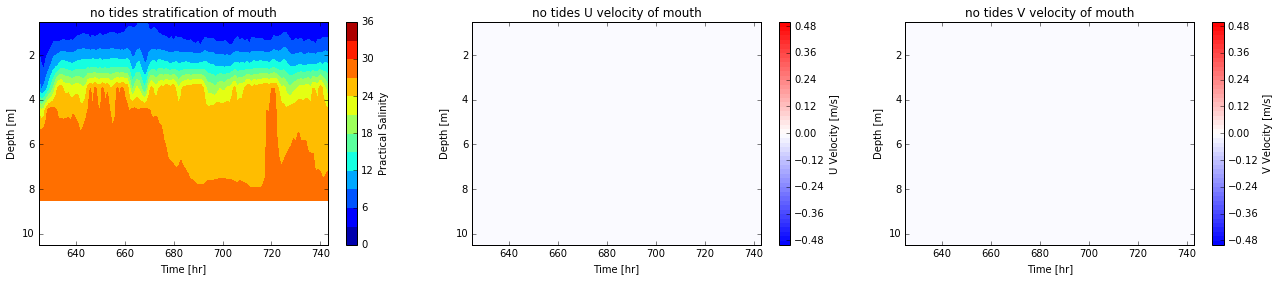

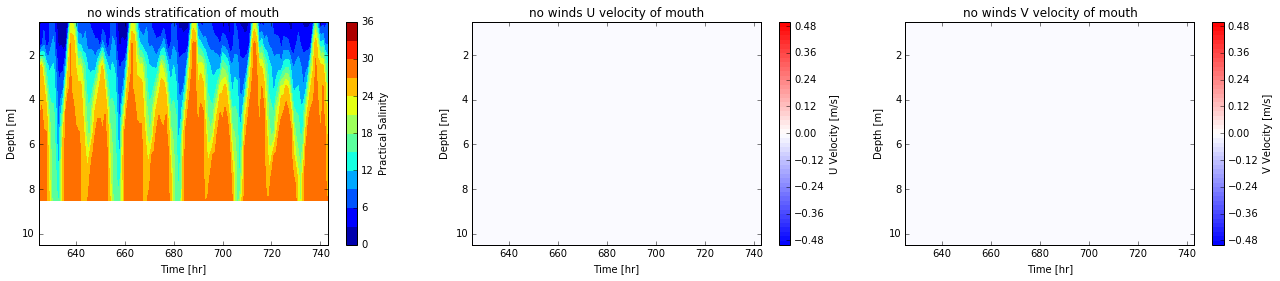

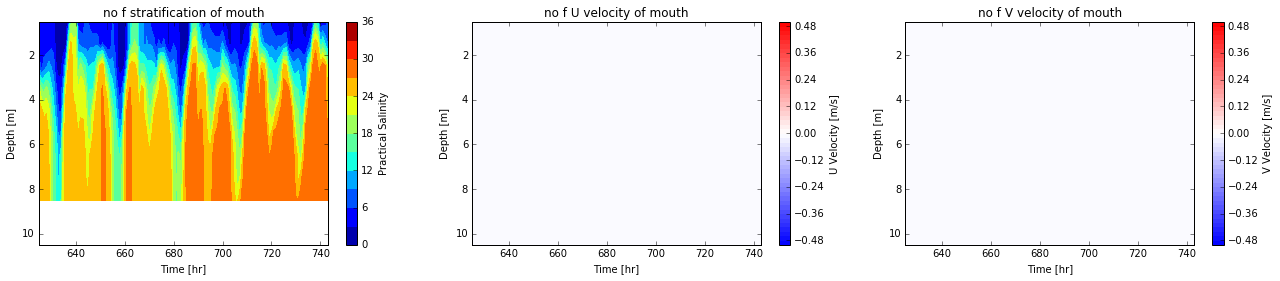

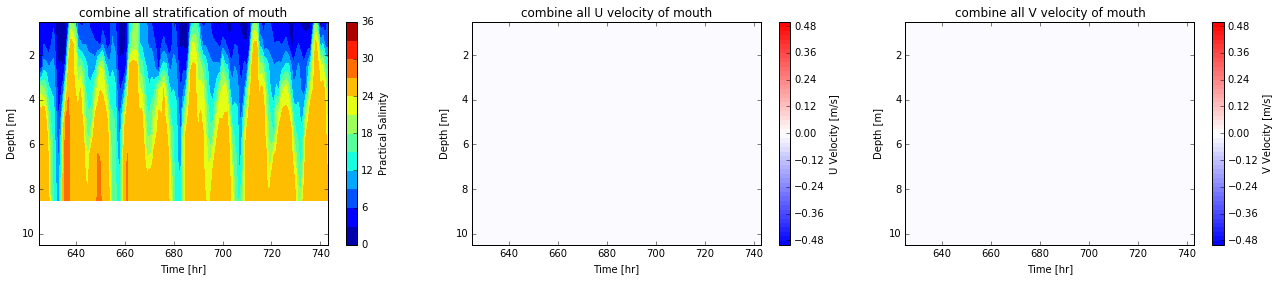

In [12]:
plot_stn('mouth')
fig = plot_stratification_current('mouth',10,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('mouth',10,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('mouth',10,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('mouth',10,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('mouth',10,'combine all',all_T,all_U,all_V,625)

* near field

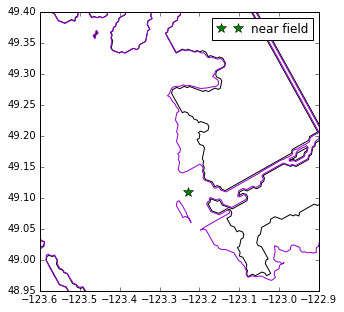

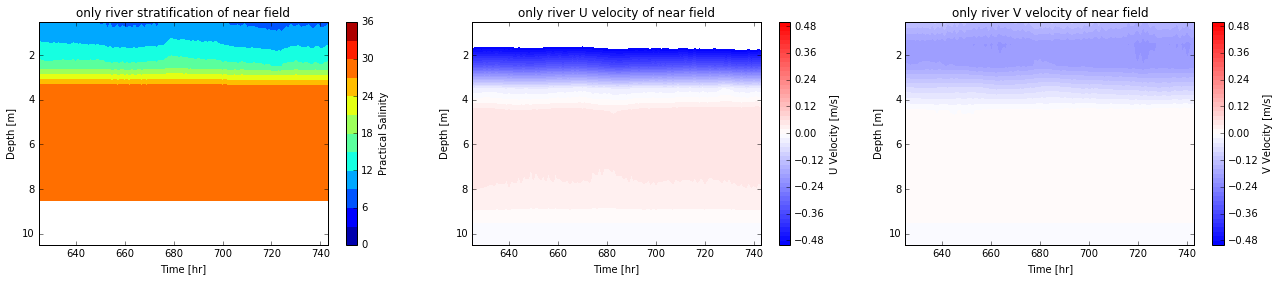

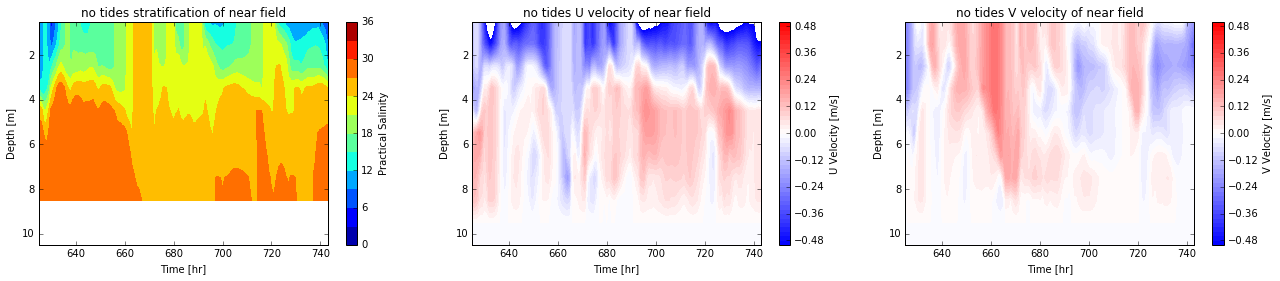

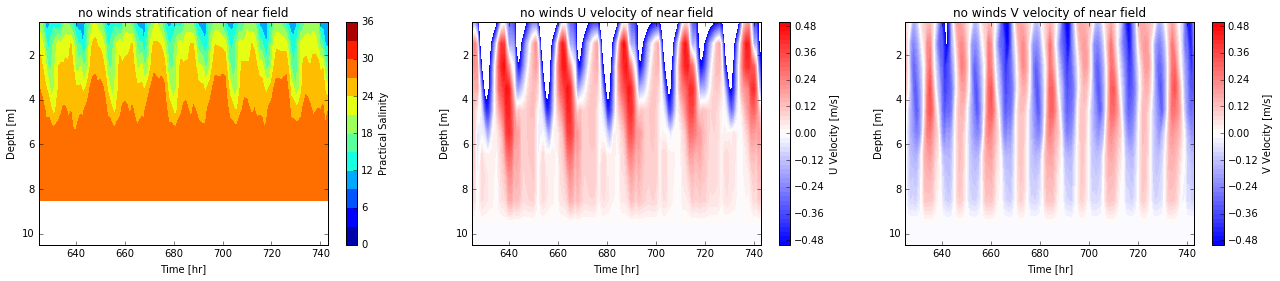

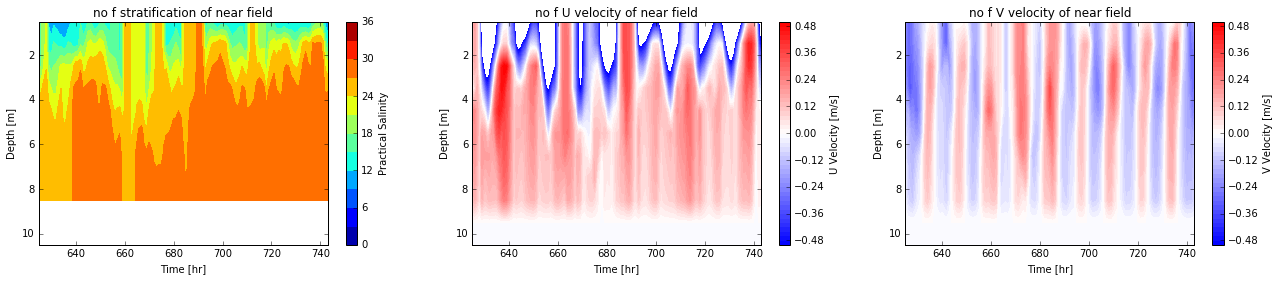

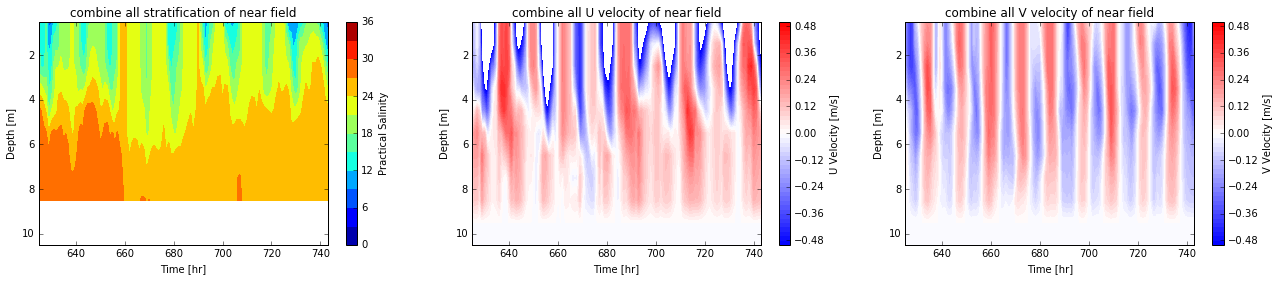

In [13]:
plot_stn('near field')
fig = plot_stratification_current('near field',10,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('near field',10,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('near field',10,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('near field',10,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('near field',10,'combine all',all_T,all_U,all_V,625)

* Sandheads

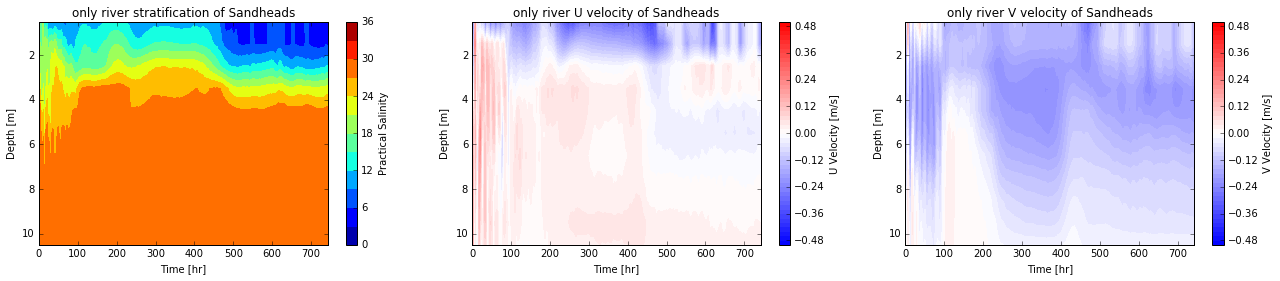

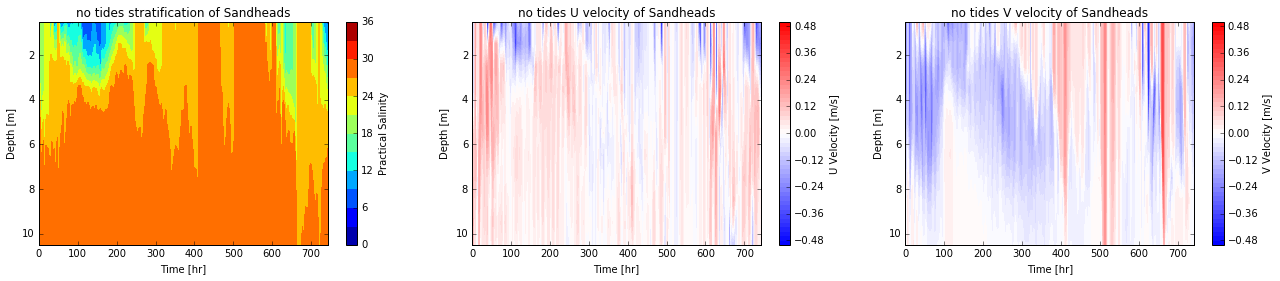

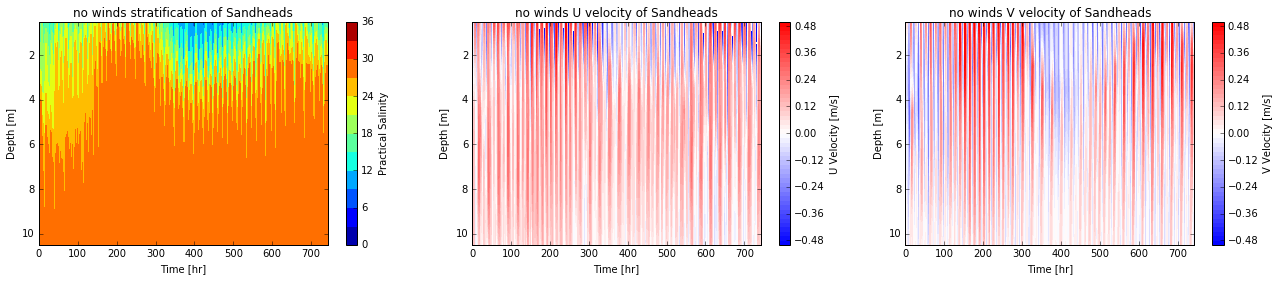

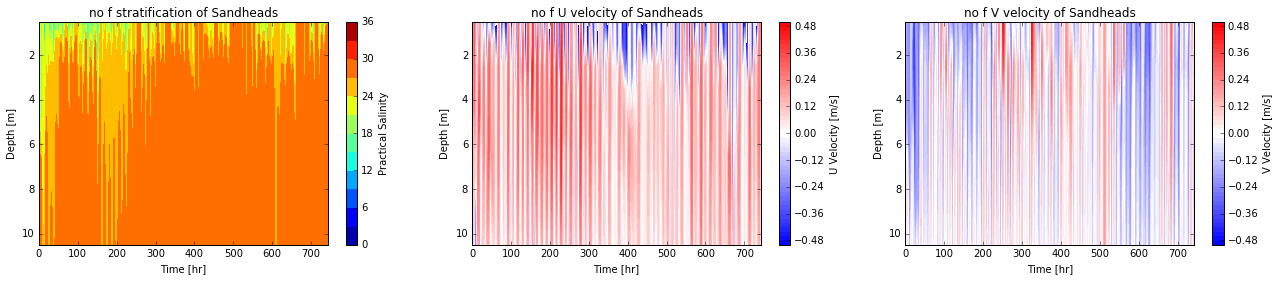

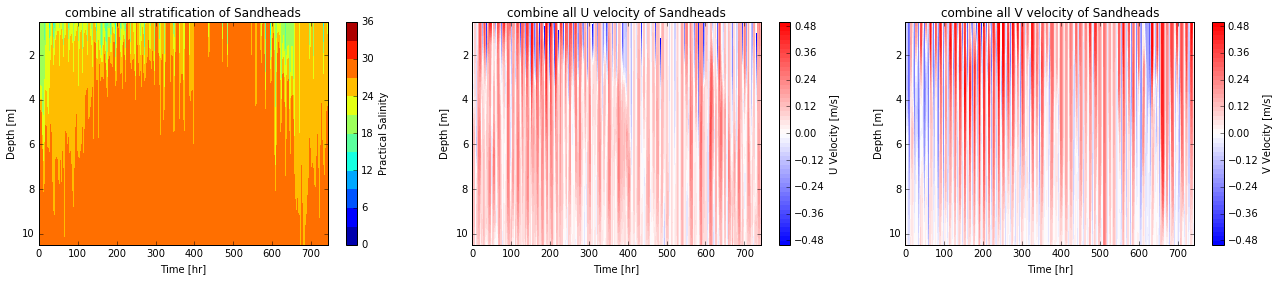

In [14]:
fig = plot_stratification_current('Sandheads',10,'only river',river_T,river_U,river_V,0)
fig = plot_stratification_current('Sandheads',10,'no tides',notide_T,notide_U,notide_V,0)
fig = plot_stratification_current('Sandheads',10,'no winds',nowind_T,nowind_U,nowind_V,0)
fig = plot_stratification_current('Sandheads',10,'no f',nof_T,nof_U,nof_V,0)
fig = plot_stratification_current('Sandheads',10,'combine all',all_T,all_U,all_V,0)

# Richardson number calculation

In [11]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho)
    """

    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s
        )

    return rho

In [12]:
def calculate_buoyancy_frequency(temp, sal, e3, depth_axis=1):
    """ Calculate the squared buoyancy frequency (n2) given temperature and
    salinity profiles. N2 is set to  g*drho/dz/rho. Note that NEMO uses a 
    defintion based on an equation of state:   
    g* (alpha dk[T] + beta dk[S] ) / e3w

    temp and sal are the temperature and salinity arrays
    e3 is an array of the vertical scale factors (grid spacing). Use e3w for
    constistency with NEMO.
    depth_axis defines the axis which corresponds to depth in the temp/sal
    arrays

    returns n2, an array of square buoyancy frequency at each point in temp/sal.
    """

    # acceleration due to gravity
    g = 9.80665
    rho0=1035 #NEMO fvalue in kg/m^3
    # First calculate density.
    rho = calculate_density(temp, sal)

    # Density gradient
    drho = np.zeros(rho.shape)
    # roll depth axis in rho and drho to first axis
    # assume e3 already has depth axis in first axis
    drho_r = np.rollaxis(drho, depth_axis)
    rho_r = np.rollaxis(rho, depth_axis)
    for k in np.arange(1, drho.shape[depth_axis]):
        drho_r[k, ...] = 1/e3[k, ...]*(rho_r[k, ...] - rho_r[k-1, ...])
    # Unroll drho
    drho = np.rollaxis(drho_r, 0, depth_axis+1)
    rho = np.rollaxis(rho_r, 0, depth_axis+1)
    # Define N2
    n2 = g*drho/rho0  # no negative because depth increases with increasking k

    return n2

(20, 0)

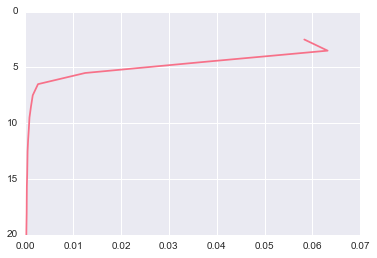

In [17]:
plt.plot(n2[0,:],dep)
plt.ylim([20,0])

In [13]:
def Richardson_value(n2,dep_ind,gridU,gridV,j,i,tst,ted,e3):
    """This function was made to calculate the 
    averaged Richardson number value over time at 
    a specific location at the depth between river
    plume water and ambient water
    definition of Ri number = N2/S2"""
    u = gridU.variables['vozocrtx']
    v = gridV.variables['vomecrty']
    ## unstagger
    UU,VV = viz_tools.unstagger(u[tst:ted+1,:,j:j+2,i:i+2],v[tst:ted+1,:,j:j+2,i:i+2])
    #rotate
    theta = np.pi*29/180
    UU = UU*np.cos(theta) - VV*np.sin(theta)
    VV = UU*np.sin(theta) +VV*np.cos(theta)
    S2 = np.zeros([UU.shape[0],UU.shape[1],UU.shape[2],UU.shape[3]])
    ## vertical shear
    for k in np.arange(1,UU.shape[1]):
        S2[:,k,...] = (1/e3[k,...]*(UU[:,k,...]-UU[:,k-1,...]))**2+\
                       (1/e3[k,...]*(VV[:,k,...]-VV[:,k-1,...]))**2 
    Ri_reverse = n2/S2[:,:,0,0]
    ##average over time at specific depth
    Ri_final = np.nanmean(Ri_reverse, axis = 0)
    return Ri_final

In [70]:
e3t = mesh.variables['e3t'][0,:,428,292]

In [14]:
import seaborn as sns
sns.set_palette("husl")

In [22]:
#rho = calculate_density(temp, sal)
#rho = np.ma.masked_less(rho, 0)
j = 43
i = 64
tst = 625
ten = 743
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
dep = river_T.variables['deptht']
e3w = mesh.variables['e3w'][0,:,j+380,i+240]
temp = river_T.variables['votemper'][tst:ten+1,:,j,i]
sal = river_T.variables['vosaline'][tst:ten+1,:,j,i]

temp_notides = notide_T.variables['votemper'][tst:ten+1,:,j,i]
sal_notides = notide_T.variables['vosaline'][tst:ten+1,:,j,i]

temp_nowinds= nowind_T.variables['votemper'][tst:ten+1,:,j,i]
sal_nowinds= nowind_T.variables['vosaline'][tst:ten+1,:,j,i]

temp_nof = nof_T.variables['votemper'][tst:ten+1,:,j,i]
sal_nof = nof_T.variables['vosaline'][tst:ten+1,:,j,i]

temp_all = all_T.variables['votemper'][tst:ten+1,:,j,i]
sal_all = all_T.variables['vosaline'][tst:ten+1,:,j,i]

n2_onlyriver = calculate_buoyancy_frequency(temp, sal, e3w)
n2_onlyriver = np.ma.masked_less(n2_onlyriver, 0)

n2_notide = calculate_buoyancy_frequency(temp_notides, sal_notides, e3w)
n2_notide = np.ma.masked_less(n2_notide, 0)

n2_nowind = calculate_buoyancy_frequency(temp_nowinds, sal_nowinds, e3w)
n2_nowind = np.ma.masked_less(n2_nowind, 0)

n2_nof = calculate_buoyancy_frequency(temp_nof, sal_nof, e3w)
n2_nof = np.ma.masked_less(n2_nof, 0)

n2_all = calculate_buoyancy_frequency(temp_all, sal_all, e3w)
n2_all = np.ma.masked_less(n2_all, 0)

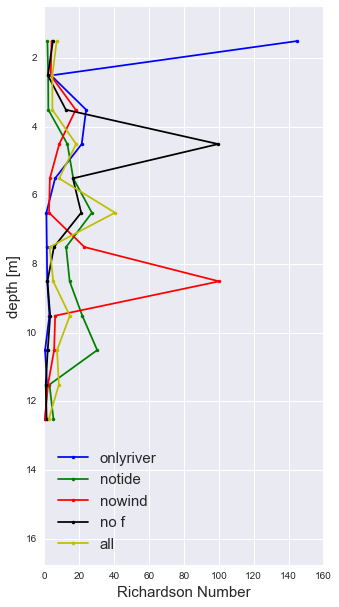

In [19]:
j =46
i = 53
## Sandheads far field
Ri_or = Richardson_value(n2_onlyriver,10,river_U,river_V,j,i,tst,ten,e3w)
Ri_notide=Richardson_value(n2_notide,4,notide_U,notide_V,j,i,tst,ten,e3w)
Ri_nowind = Richardson_value(n2_nowind,10,nowind_U,nowind_V,j,i,tst,ten,e3w)
Ri_nof = Richardson_value(n2_nof,10,nof_U,nof_V,j,i,tst,ten,e3w)
Ri_all = Richardson_value(n2_all,10,all_U,all_V,j,i,tst,ten,e3w)
fig, ax = plt.subplots(1,1,figsize = (5,10))
import seaborn as sns

ax.plot(Ri_or,dep,'b.-',label = 'onlyriver')
ax.plot(Ri_notide,dep,'g.-',label = 'notide')
ax.plot(Ri_nowind,dep,'r.-',label = 'nowind')
ax.plot(Ri_nof,dep,'k.-',label = 'no f')
ax.plot(Ri_all,dep,'y.-',label = 'all')
ax.set_ylim([dep[16],dep[0]])
ax.legend(loc = 'best',fontsize = 15)
ax.set_xlabel('Richardson Number',fontsize = 15)
ax.set_ylabel('depth [m]',fontsize = 15)

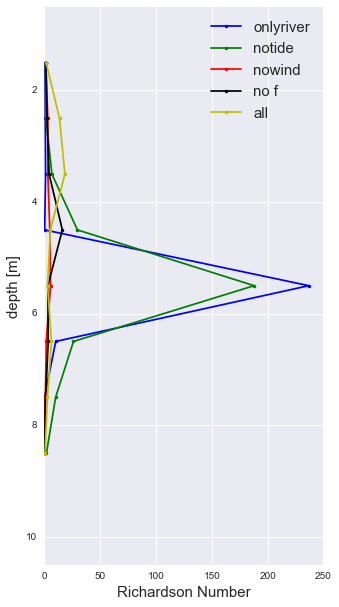

In [24]:
## near field
j =43
i = 64

Ri_or = Richardson_value(n2_onlyriver,10,river_U,river_V,j,i,tst,ten,e3w)
Ri_notide=Richardson_value(n2_notide,4,notide_U,notide_V,j,i,tst,ten,e3w)
Ri_nowind = Richardson_value(n2_nowind,10,nowind_U,nowind_V,j,i,tst,ten,e3w)
Ri_nof = Richardson_value(n2_nof,10,nof_U,nof_V,j,i,tst,ten,e3w)
Ri_all = Richardson_value(n2_all,10,all_U,all_V,j,i,tst,ten,e3w)
fig, ax = plt.subplots(1,1,figsize = (5,10))
import seaborn as sns

ax.plot(Ri_or,dep,'b.-',label = 'onlyriver')
ax.plot(Ri_notide,dep,'g.-',label = 'notide')
ax.plot(Ri_nowind,dep,'r.-',label = 'nowind')
ax.plot(Ri_nof,dep,'k.-',label = 'no f')
ax.plot(Ri_all,dep,'y.-',label = 'all')
ax.set_ylim([dep[10],dep[0]])
ax.legend(loc = 'best',fontsize = 15)
ax.set_xlabel('Richardson Number',fontsize = 15)
ax.set_ylabel('depth [m]',fontsize = 15)

In [74]:
a = Richardson_value(n2,4,notide_U,notide_V,48,52,625,743,e3w)
a.shape

(40,)

In [63]:
a = Richardson_value(n2,10,nowind_U,nowind_V,48,52,625,743,e3w)
a

0.66663286579725012

In [68]:
a = Richardson_value(n2,10,nof_U,nof_V,48,52,625,743,e3w)
a

0.83840134146072243

In [69]:
a = Richardson_value(n2,10,all_U,all_V,48,52,625,743,e3w)
a

0.67246155456344825

* zoom in last five days

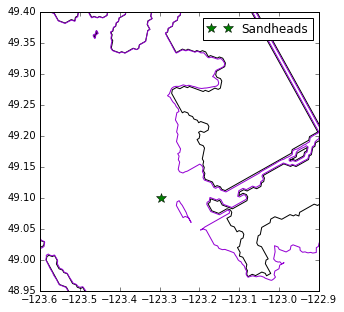

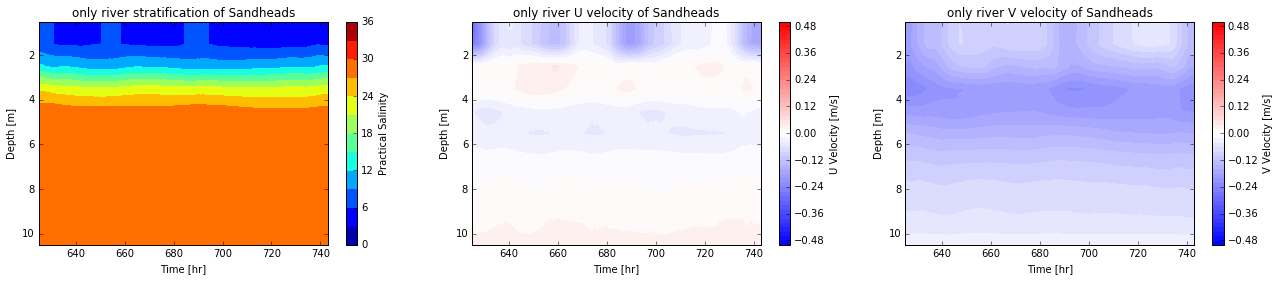

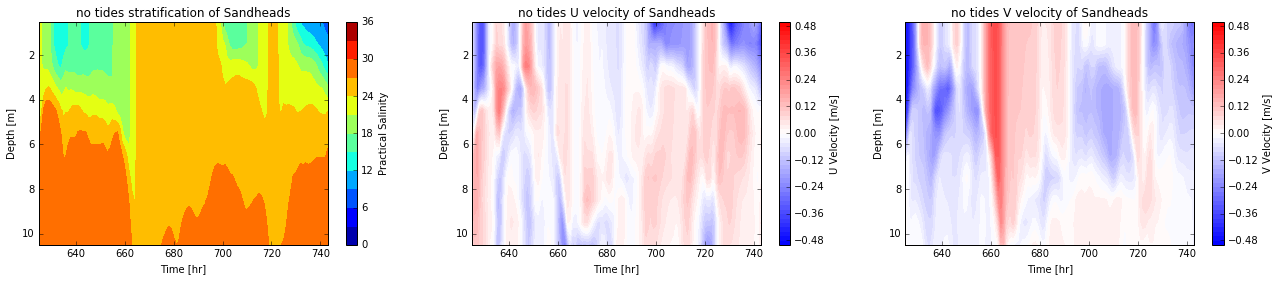

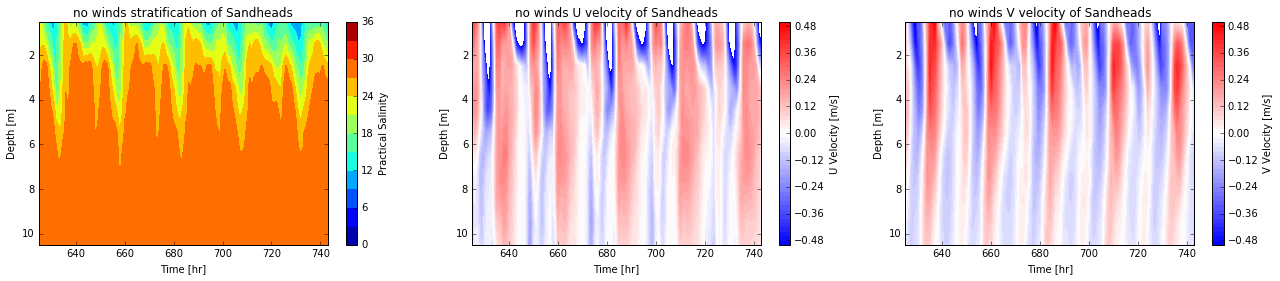

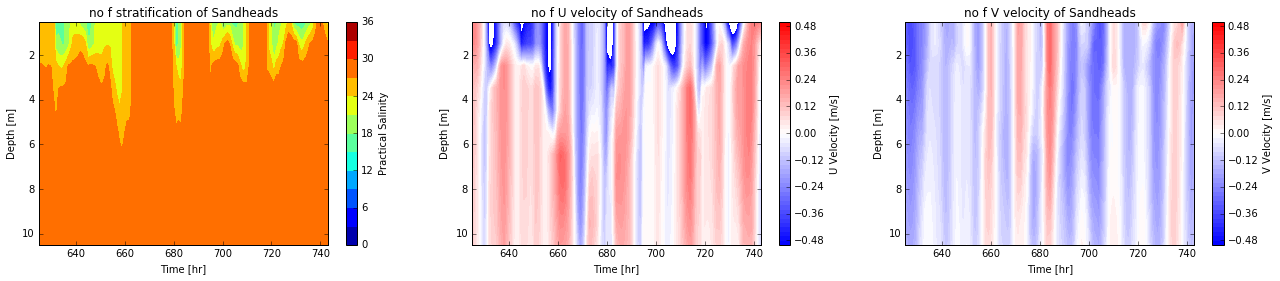

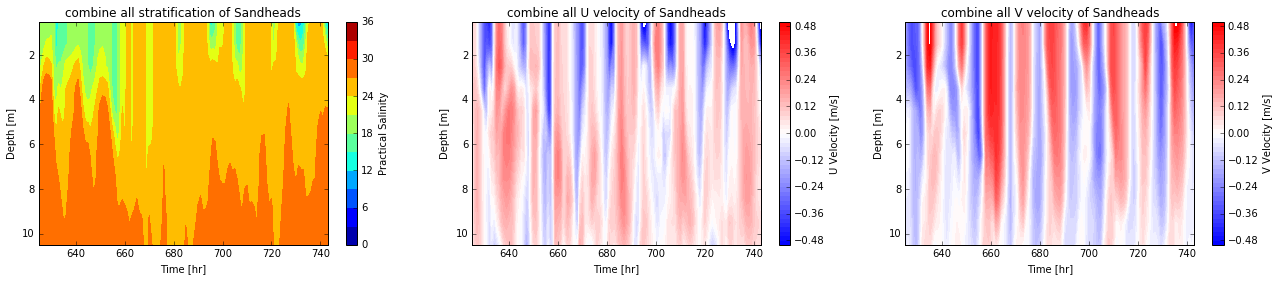

In [15]:
plot_stn('Sandheads')
fig = plot_stratification_current('Sandheads',10,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('Sandheads',10,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('Sandheads',10,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('Sandheads',10,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('Sandheads',10,'combine all',all_T,all_U,all_V,625)

* Steveston

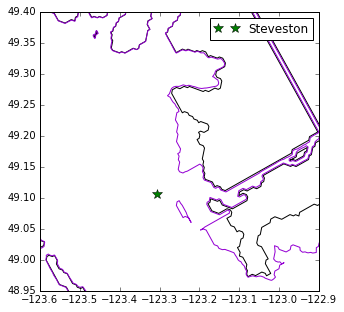

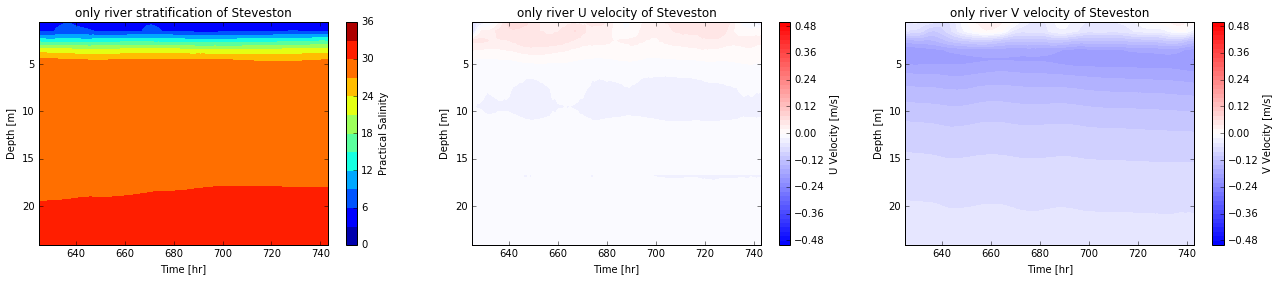

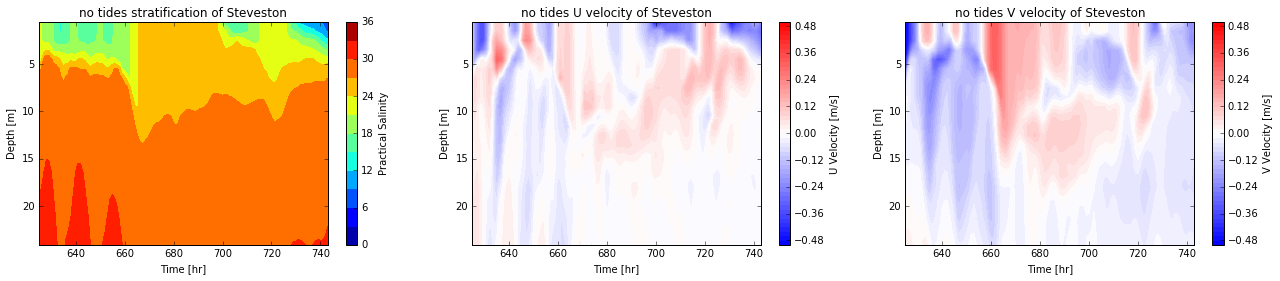

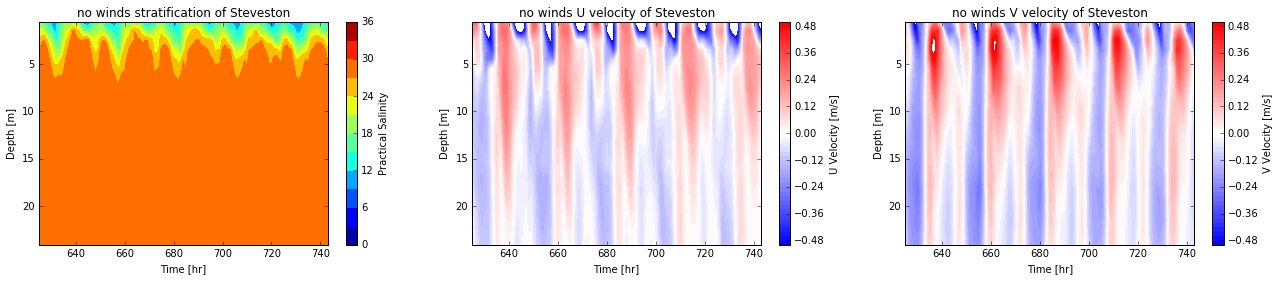

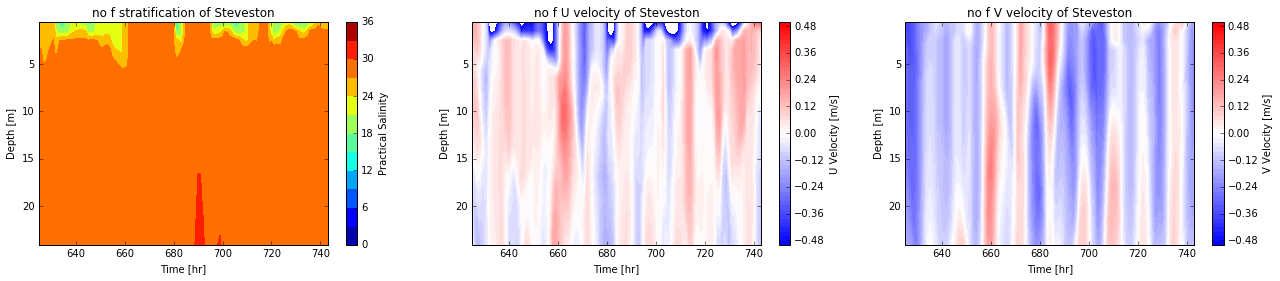

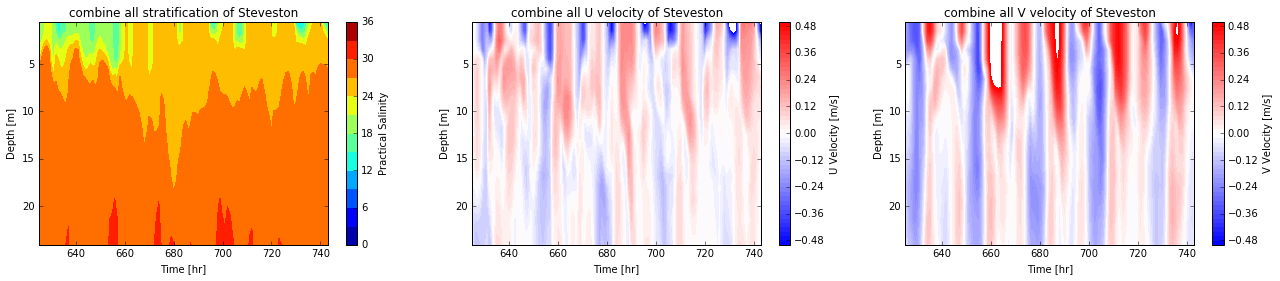

In [16]:
plot_stn('Steveston')
fig = plot_stratification_current('Steveston',20,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('Steveston',20,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('Steveston',20,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('Steveston',20,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('Steveston',20,'combine all',all_T,all_U,all_V,625)

* VENUS Central

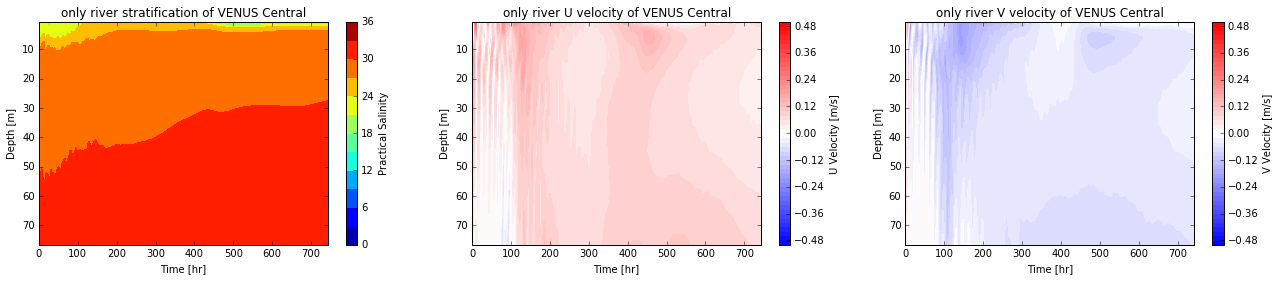

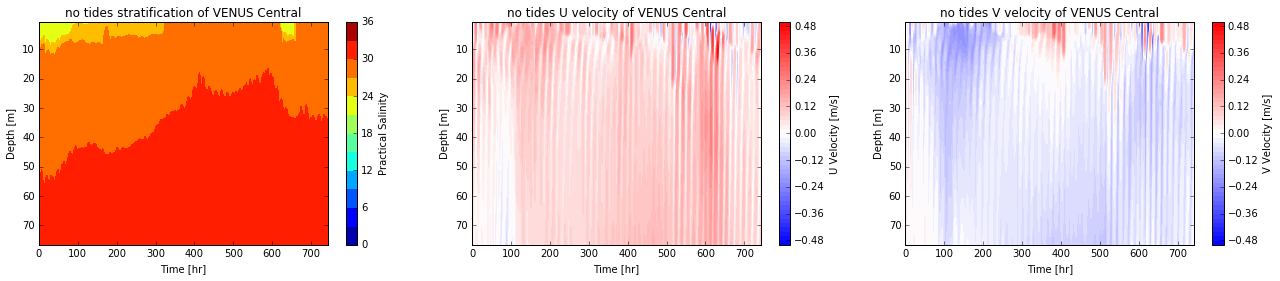

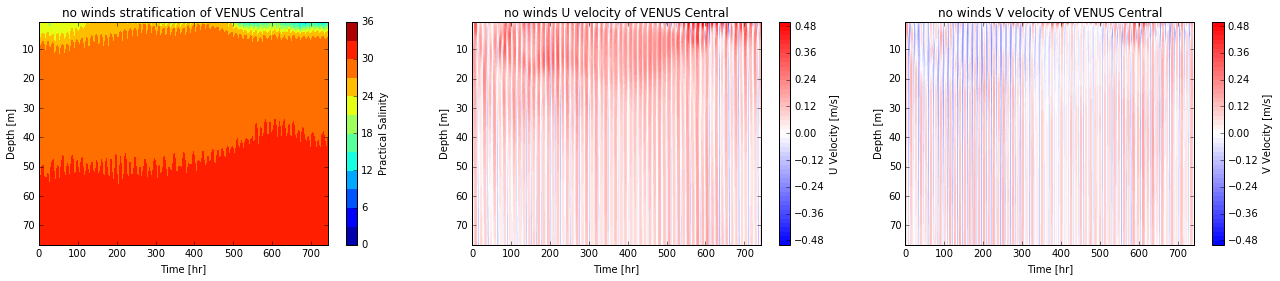

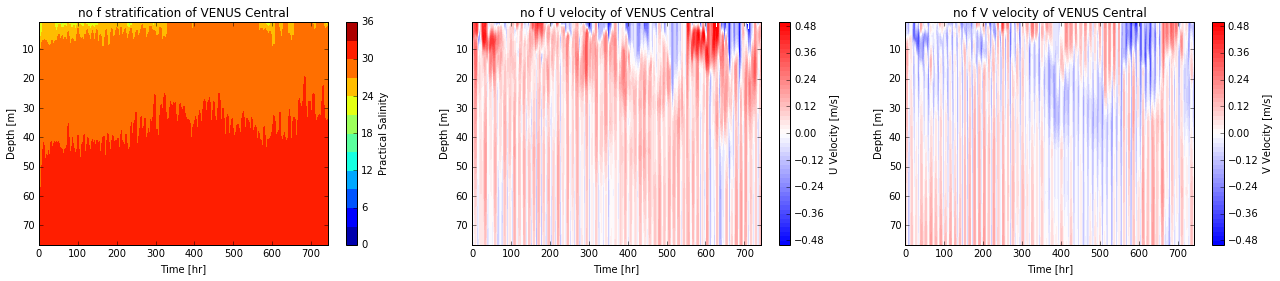

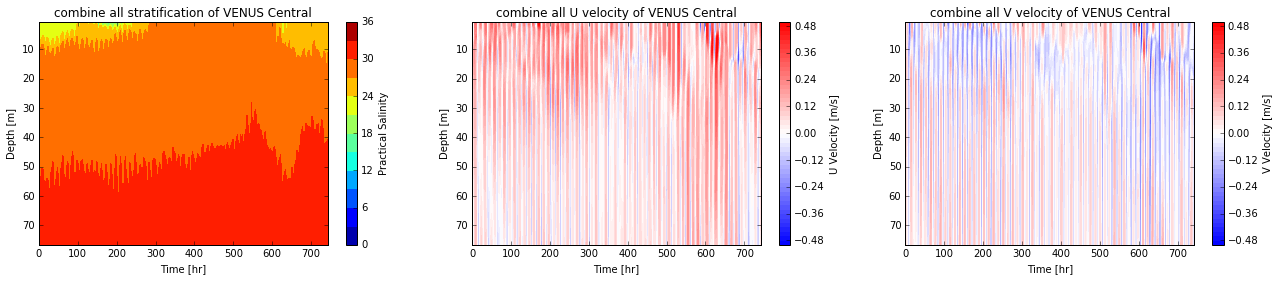

In [17]:
fig = plot_stratification_current('VENUS Central',25,'only river',river_T,river_U,river_V,0)
fig = plot_stratification_current('VENUS Central',25,'no tides',notide_T,notide_U,notide_V,0)
fig = plot_stratification_current('VENUS Central',25,'no winds',nowind_T,nowind_U,nowind_V,0)
fig = plot_stratification_current('VENUS Central',25,'no f',nof_T,nof_U,nof_V,0)
fig = plot_stratification_current('VENUS Central',25,'combine all',all_T,all_U,all_V,0)

* zoom in last five days

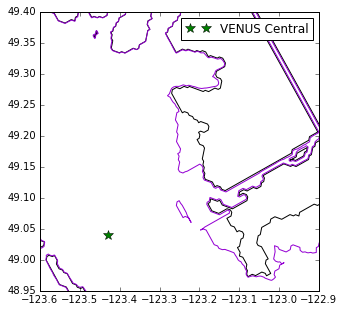

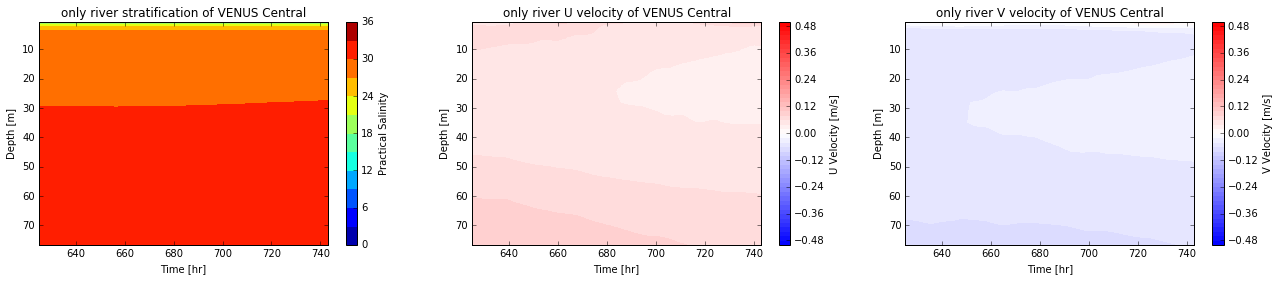

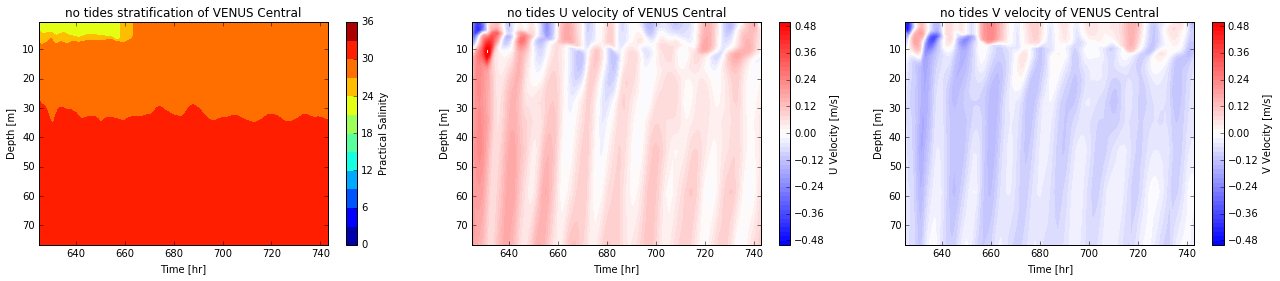

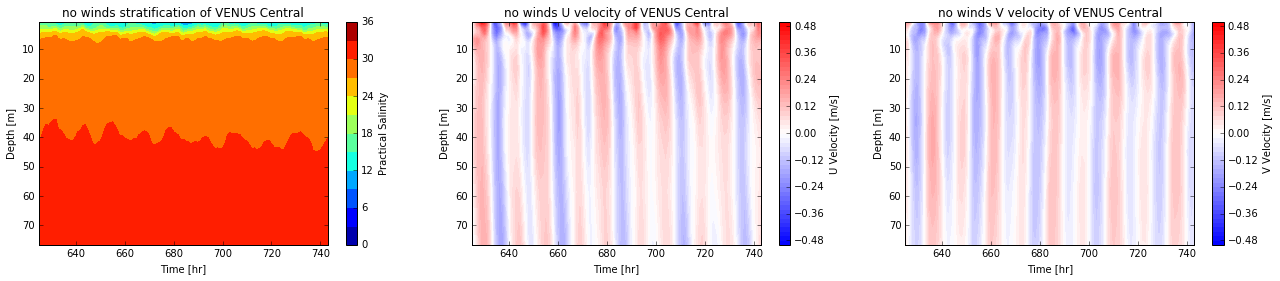

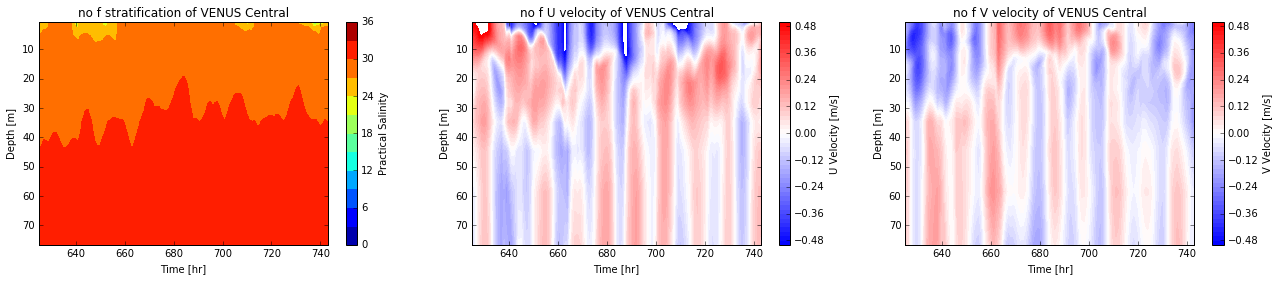

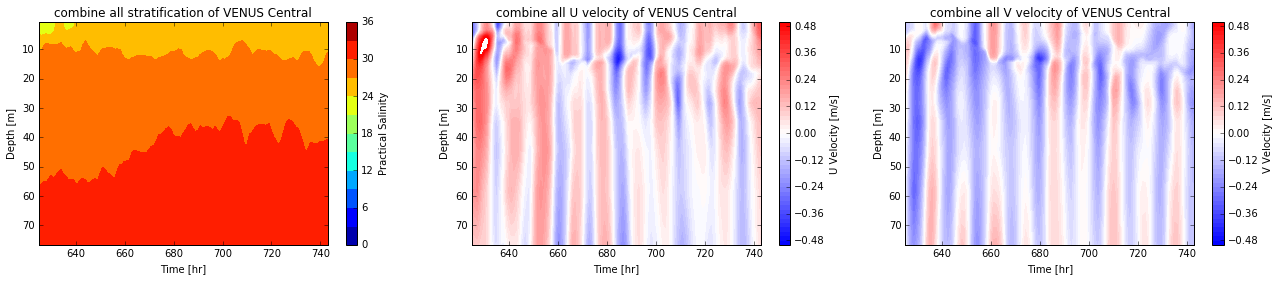

In [18]:
plot_stn('VENUS Central')
fig = plot_stratification_current('VENUS Central',25,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('VENUS Central',25,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('VENUS Central',25,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('VENUS Central',25,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('VENUS Central',25,'combine all',all_T,all_U,all_V,625)

# Final circulation pattern

In [23]:
def plot_spatial_circulation(grid_T,grid_U,grid_V,dep_ind,string,smin = 0,smax = 30,st=3):
    """This function was made to plot the circulation pattern of each case of 
    the final time"""
    fig, ax= plt.subplots(1,1,figsize=(6,6))
    S = grid_T.variables['vosaline'][-1,dep_ind,:,:]
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    U = grid_U.variables['vozocrtx']
    V = grid_V.variables['vomecrty']
    UU,VV = viz_tools.unstagger(U[-1,dep_ind,:,:],V[-1,dep_ind,:,:])
    #rotate
    theta = np.pi*29/180
    UU = UU*np.cos(theta) - VV*np.sin(theta)
    VV = UU*np.sin(theta) +VV*np.cos(theta)
    mesh=ax.pcolormesh(lon,lat,S[:],cmap='spectral')
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label('Practical Salinity')
    mesh.set_clim(vmin=smin, vmax=smax)
    #quivers
    lon = grid_T.variables['nav_lon'][:-1,:-1]
    lat = grid_T.variables['nav_lat'][:-1,:-1]
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st], UU[::st,::st], VV[::st,::st],
                pivot='mid', width=0.003,scale=5, color='black',headwidth=2,headlength=2)
    ax.quiverkey(quiver,-123.1,49.2, 0.5, '0.5 m/s',
                 coordinates='data', color='black', labelcolor='black')
    #land
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.set_xlim([-123.75,-122.8])
    ax.set_ylim([48.85,49.4])
    ax.set_title(string)
    return fig

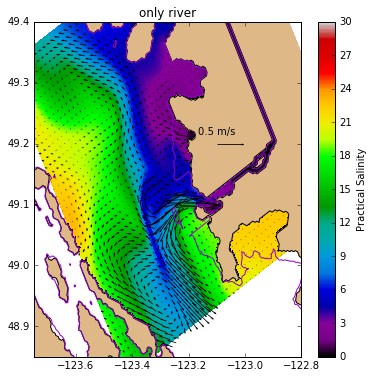

In [24]:
fig = plot_spatial_circulation(river_T,river_U,river_V,0,'only river')

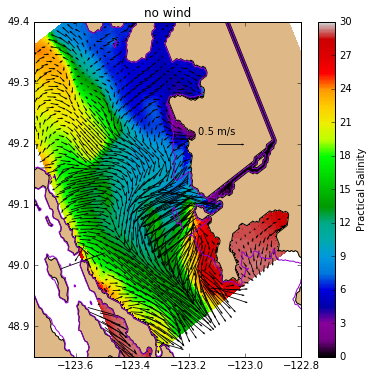

In [25]:
fig = plot_spatial_circulation(nowind_T,nowind_U,nowind_V,0,'no wind')

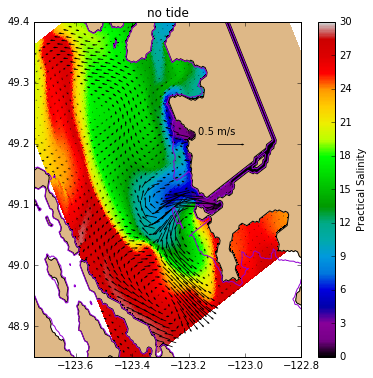

In [26]:
fig = plot_spatial_circulation(notide_T,notide_U,notide_V,0,'no tide')

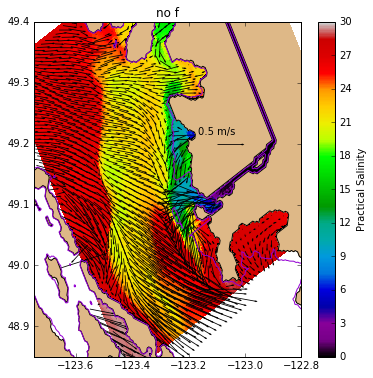

In [27]:
fig = plot_spatial_circulation(nof_T,nof_U,nof_V,0,'no f')

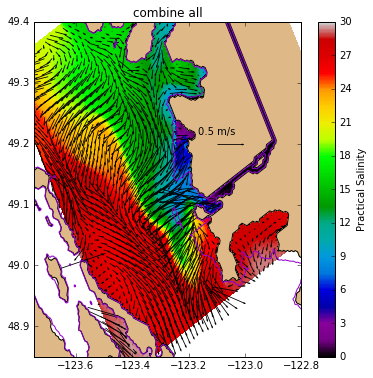

In [28]:
fig = plot_spatial_circulation(all_T,all_U,all_V,0,'combine all')